In [1]:
!pip install cloud_tpu_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 KB 14.6 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.0
    Uninstalling google-api-core-2.11.0:
      Successfully uninstalled google-api-core-2.11.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.70.0
    Uninstalling google-api-python-client-2.70.0:
      Successfully uninstalled google-api-python-client-2.70.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [2]:
!pip install tf-models-official==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=0fd1bd27d9f265b3fa2a2a44127de86aeb4304139eed217c32b87660e2108933
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import transformers
from transformers import AutoTokenizer, TFAutoModel

import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import losses

import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.colors import LogNorm, CenteredNorm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import json
import shutil
import os
import zipfile

# For nicer prints
from IPython.display import display

tf_version = tf.__version__
print(tf_version)

2.9.2


In [5]:
from official.nlp import optimization

In [6]:
try:
    # Sync the TPU to the tensorflow version used in this notebook
    from cloud_tpu_client import Client
    c = Client()
    c.configure_tpu_version(tf.__version__, restart_type='ifNeeded')
    
    
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. If a GPU is available, it will be utilized with this strategy.
    strategy = tf.distribute.get_strategy()

print("Number of replicas: ", strategy.num_replicas_in_sync)

Number of replicas:  1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Roberta_Referat/data/news"
dataset_path = '/content/drive/MyDrive/Roberta_Referat/data/news/full_data/'

Mounted at /content/drive


In [8]:
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    return df[["headline", "category"]]

dataframe = load_data('/content/drive/MyDrive/Roberta_Referat/data/news/full_data/classification_news.jsonl')
dataframe.head()

,headline,category
0,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,ENTERTAINMENT


In [9]:
def codify_labels(df):
    label = dict( zip( df['category'].cat.codes, df['category'] ) )
    category_code = dict( zip( df['category'], df['category'].cat.codes ) )
    df['category'] = df.category.cat.codes
    return label, category_code

label, category_code = codify_labels(dataframe)
display(label)

{5: 'CRIME',
 9: 'ENTERTAINMENT',
 33: 'WORLD',
 15: 'IMPACT',
 19: 'POLITICS',
 30: 'WEIRD NEWS',
 1: 'BLACK VOICES',
 32: 'WOMEN',
 4: 'COMEDY',
 20: 'QUEER VOICES',
 23: 'SPORTS',
 2: 'BUSINESS',
 28: 'TRAVEL',
 16: 'MEDIA',
 27: 'TECH',
 21: 'RELIGION',
 22: 'SCIENCE',
 8: 'EDUCATION',
 3: 'COLLEGE',
 18: 'PARENTING',
 0: 'ARTS & CULTURE',
 24: 'STYLE',
 10: 'ENVIRONMENT',
 26: 'TASTE',
 13: 'HEALTHY LIVING',
 12: 'GOOD NEWS',
 11: 'FIFTY',
 6: 'CULTURE & ARTS',
 31: 'WELLNESS',
 14: 'HOME & LIVING',
 25: 'STYLE & BEAUTY',
 7: 'DIVORCE',
 29: 'WEDDINGS',
 17: 'MONEY'}

In [10]:
categories = dataframe["category"].unique()
display(categories)

array([ 5,  9, 33, 15, 19, 30,  1, 32,  4, 20, 23,  2, 28, 16, 27, 21, 22,
        8,  3, 18,  0, 24, 10, 26, 13, 12, 11,  6, 31, 14, 25,  7, 29, 17],
      dtype=int8)

In [11]:
def split_dataset(df, seed=42, percentage_train=0.8, percentage_validation=0.15, percentage_test=0.05):
    assert percentage_train + percentage_validation + percentage_test == 1

    dataset_size = len(df)
    
    headlines_train, headlines_rest, categories_train, categories_rest = train_test_split(df["headline"], df["category"], random_state=seed, test_size=0.2)
    headlines_validation, headlines_test, categories_validation, categories_test = train_test_split(headlines_rest, categories_rest, random_state=seed, test_size=0.25)

    train_df = pd.concat([categories_train, headlines_train], axis=1)
    train_df.columns = ["category", "headline"]
    validation_df = pd.concat([categories_validation, headlines_validation], axis=1)
    validation_df.columns = ["category", "headline"]
    test_df = pd.concat([categories_test, headlines_test], axis=1)
    test_df.columns = ["category", "headline"]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = split_dataset(dataframe)

display(train_df.head())

,category,headline
92781,22,NASA Astronauts' GoPro Captures ISS Spacewalk
35179,9,How Train’s Pat Monahan Continues To Create Hit After Hit
159369,26,"Bartender, We're Here for the Science!"
101899,13,Alexandria Crow: Why You Should Teach Anatomy and Alignment in Yoga
39281,27,Reducing U.S. Cyber Risk And The 45th President: A New Approach


In [12]:
pretrained_model = "roberta-base"

In [13]:
class TextEncoder:
    def __init__(self, max_length=70):
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.max_length = max_length
    
    def encode(self, texts):
        texts = texts.apply(lambda s: s.lower())
        encoded_texts = self.tokenizer.batch_encode_plus(list(texts), padding='max_length', 
                                                     truncation=True, max_length=self.max_length, 
                                                     add_special_tokens=True,
                                                     return_token_type_ids=False,
                                                     return_attention_mask=True)
        return np.array(encoded_texts["input_ids"]), np.array(encoded_texts["attention_mask"])
        
max_length = 70
encoder = TextEncoder(max_length=max_length)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [14]:
train_ids, train_attention_mask = encoder.encode(train_df["headline"])
validation_ids, validation_attention_mask = encoder.encode(validation_df["headline"])
test_ids, test_attention_mask = encoder.encode(test_df["headline"])

In [15]:
def compose_dataset(word_ids, attention_masks, categories):
    ids_ds = tf.data.Dataset.from_tensor_slices(word_ids)
    attention_mask_ds = tf.data.Dataset.from_tensor_slices(attention_masks)
    y_ds = tf.data.Dataset.from_tensor_slices(categories)
    x_ds = tf.data.Dataset.zip((ids_ds, attention_mask_ds))
    return tf.data.Dataset.zip((x_ds, y_ds))

train_ds = compose_dataset(train_ids, train_attention_mask, train_df["category"].values)
validation_ds = compose_dataset(validation_ids, validation_attention_mask, validation_df["category"].values)
test_ds = compose_dataset(test_ids, test_attention_mask, test_df["category"].values)

In [16]:
#if tpu:
#    batch_size = 32 * strategy.num_replicas_in_sync
#else:
batch_size = 32

batch_train_ds = train_ds.batch(batch_size)
batch_validation_ds = validation_ds.batch(batch_size)
batch_test_ds = test_ds.batch(batch_size)
    
AUTOTUNE = tf.data.AUTOTUNE

batch_train_ds = batch_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
batch_validation_ds = batch_validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
batch_test_ds = batch_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
class ModelBuilder:
    def __init__(self, init_lr, num_train_steps):
        self.metric = [tf.metrics.SparseCategoricalAccuracy(), tf.metrics.SparseTopKCategoricalAccuracy(3)]
        num_warmup_steps = int(0.1*num_train_steps)
        self.optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
        
    def build_model(self):
        auto_model = transformers.TFAutoModel.from_pretrained(pretrained_model, return_dict=True)
        
        word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='word_ids')
        attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
        pooler_output = auto_model(input_ids=word_ids, attention_mask=attention_masks)["pooler_output"]
        drop_out = tf.keras.layers.Dropout(0.1)(pooler_output)
        output = tf.keras.layers.Dense(len(categories), activation='softmax')(drop_out)
        model = tf.keras.Model(inputs=[word_ids, attention_masks], outputs=output)
        
        model.compile(self.optimizer, metrics=self.metric, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
        return model
    
    def build_sequence_classifier_model(self):
        auto_model = transformers.TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, return_dict=True, num_labels=len(categories))
        
        word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='word_ids')
        attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
        output = auto_model(input_ids=word_ids, attention_mask=attention_masks)["logits"]
        model = tf.keras.Model(inputs=[word_ids, attention_masks], outputs=output)
        
        model.compile(self.optimizer, metrics=self.metric, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        return model

In [18]:
model_name = "roberta_base_news_dataset"

In [19]:
epochs = 5

with strategy.scope():
    steps_per_epoch = tf.data.experimental.cardinality(batch_train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    model_builder = ModelBuilder(3e-5, num_train_steps)
    model = model_builder.build_sequence_classifier_model()
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_ids (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 70)]         0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124671778  ['word_ids[0][0]',               
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_masks[0][0]']        
 Classification)                logits=(None, 34),                                                
                                 hidden_states=None                                           

In [20]:
model_loaded = False
if not model_loaded:
    steps_per_epoch = tf.data.experimental.cardinality(batch_train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    history = model.fit(x=batch_train_ds,
                        validation_data=batch_validation_ds,
                        epochs=epochs)
                        # class_weight=class_weights)


Epoch 1/5
4994/4994 [==============================] - 2539s 504ms/step - loss: 1.6670 - sparse_categorical_accuracy: 0.5606 - sparse_top_k_categorical_accuracy: 0.7576 - val_loss: 1.1820 - val_sparse_categorical_accuracy: 0.6642 - val_sparse_top_k_categorical_accuracy: 0.8648
Epoch 2/5
4994/4994 [==============================] - 2515s 504ms/step - loss: 1.0923 - sparse_categorical_accuracy: 0.6870 - sparse_top_k_categorical_accuracy: 0.8761 - val_loss: 1.0962 - val_sparse_categorical_accuracy: 0.6865 - val_sparse_top_k_categorical_accuracy: 0.8795
Epoch 3/5
4994/4994 [==============================] - 2519s 504ms/step - loss: 0.8870 - sparse_categorical_accuracy: 0.7408 - sparse_top_k_categorical_accuracy: 0.9092 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.6929 - val_sparse_top_k_categorical_accuracy: 0.8817
Epoch 4/5
4994/4994 [==============================] - 2517s 504ms/step - loss: 0.7314 - sparse_categorical_accuracy: 0.7832 - sparse_top_k_categorical_accuracy: 0.93

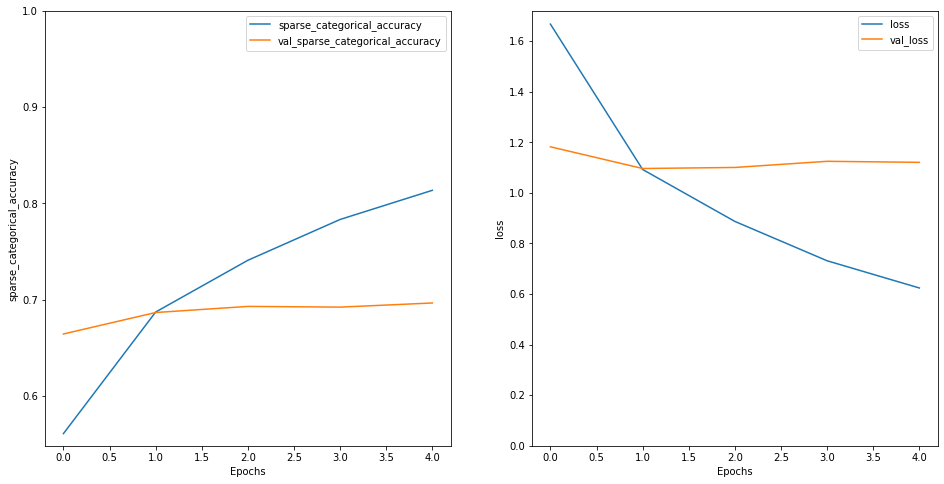

In [21]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

if not model_loaded:
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'sparse_categorical_accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)

In [22]:
loss, accuracy, top_k_accuracy = model.evaluate(batch_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Top-k accuracy: ", top_k_accuracy)

313/313 [==============================] - 49s 157ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.6906 - sparse_top_k_categorical_accuracy: 0.8796
Loss:  1.1375532150268555
Accuracy:  0.6905977725982666
Top-k accuracy:  0.8796435594558716


In [25]:
predictions = model.predict(batch_test_ds,verbose = 1)
predicted_categories = [label[np.argmax(prediction)] for prediction in predictions]
true_categories = []
for _, categories in batch_test_ds:
    for category in categories:
        true_categories.append(label[category.numpy()])

313/313 [==============================] - 54s 160ms/step


In [26]:
result_df = pd.DataFrame({'description':test_df["headline"],'true_category':true_categories, 'predicted_category':predicted_categories})
display(result_df)

,description,true_category,predicted_category
155873,Healthy Breakfast Ideas: What Health Editors Eat In The Morning,WELLNESS,WELLNESS
186424,Rhinovirus Infection Common Even Among Those Without Symptoms: Study,WELLNESS,WELLNESS
23573,2 Gay Men Open Up About Alleged Torture In Chechnya,QUEER VOICES,QUEER VOICES
127666,Table Talk: The Meaning Of Lent,PARENTING,PARENTING
72181,Donations Pour In For Father Of 6 Killed In San Bernardino Shooting,IMPACT,CRIME
...,...,...,...
104877,Lindsey Graham: 'Shame On Us As Republicans',POLITICS,POLITICS
119748,Hayden Panettiere Is Pregnant!,ENTERTAINMENT,ENTERTAINMENT
69536,The Problem With Science Journalism: We’ve Forgotten That Reality Matters Most,MEDIA,SCIENCE
197041,Viola Davis: Filmography (VIDEO),BLACK VOICES,ENTERTAINMENT


In [27]:
from sklearn.metrics import classification_report
report = classification_report(true_categories, predicted_categories)
print(report)

                precision    recall  f1-score   support

ARTS & CULTURE       0.42      0.32      0.37        74
  BLACK VOICES       0.52      0.54      0.53       229
      BUSINESS       0.54      0.55      0.55       271
       COLLEGE       0.55      0.52      0.53        60
        COMEDY       0.57      0.51      0.54       260
         CRIME       0.65      0.62      0.63       181
CULTURE & ARTS       0.55      0.55      0.55       111
       DIVORCE       0.75      0.70      0.72       180
     EDUCATION       0.47      0.38      0.42        40
 ENTERTAINMENT       0.73      0.76      0.74       765
   ENVIRONMENT       0.53      0.58      0.55       192
         FIFTY       0.49      0.38      0.43        60
     GOOD NEWS       0.40      0.30      0.34        64
HEALTHY LIVING       0.45      0.35      0.39       327
 HOME & LIVING       0.81      0.82      0.82       210
        IMPACT       0.35      0.34      0.35       143
         MEDIA       0.57      0.52      0.54  

In [29]:
confusion_mat = confusion_matrix(y_true = true_categories, y_pred = predicted_categories, labels=list(label.values()))
confusion_mat

array([[112,   3,   3, ...,   0,   0,   0],
       [  2, 583,   2, ...,   4,   1,   0],
       [  4,   2, 343, ...,   0,   0,   0],
       ...,
       [  0,   3,   0, ..., 126,   5,   0],
       [  0,   2,   0, ...,   2, 156,   1],
       [  1,   0,   0, ...,   2,   1,  43]])

In [41]:
from sklearn.utils.multiclass import unique_labels
def plot_and_store_confusion_matrix(y_true: list,
                                    y_pred:list,
                                    normalize=True,
                                    cmap=plt.cm.Blues,
                                    show=False):
    """
    This function prints and plots the confusion matrix, and saves it to a file
    :param y_true: The true classes
    :param y_pred: The predicted classes
    :param file_name: The file name to store the image of the confusion matrix
    :param normalize: normalize numbers (counts to relative counts)
    :param cmap: Layout
    :param show: Display the matrix. If false, only store it
    :return: Nothing
    """
    np.set_printoptions(precision=3)
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=[25,18])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label.values(), yticklabels=label.values(),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if show:
        plt.show()

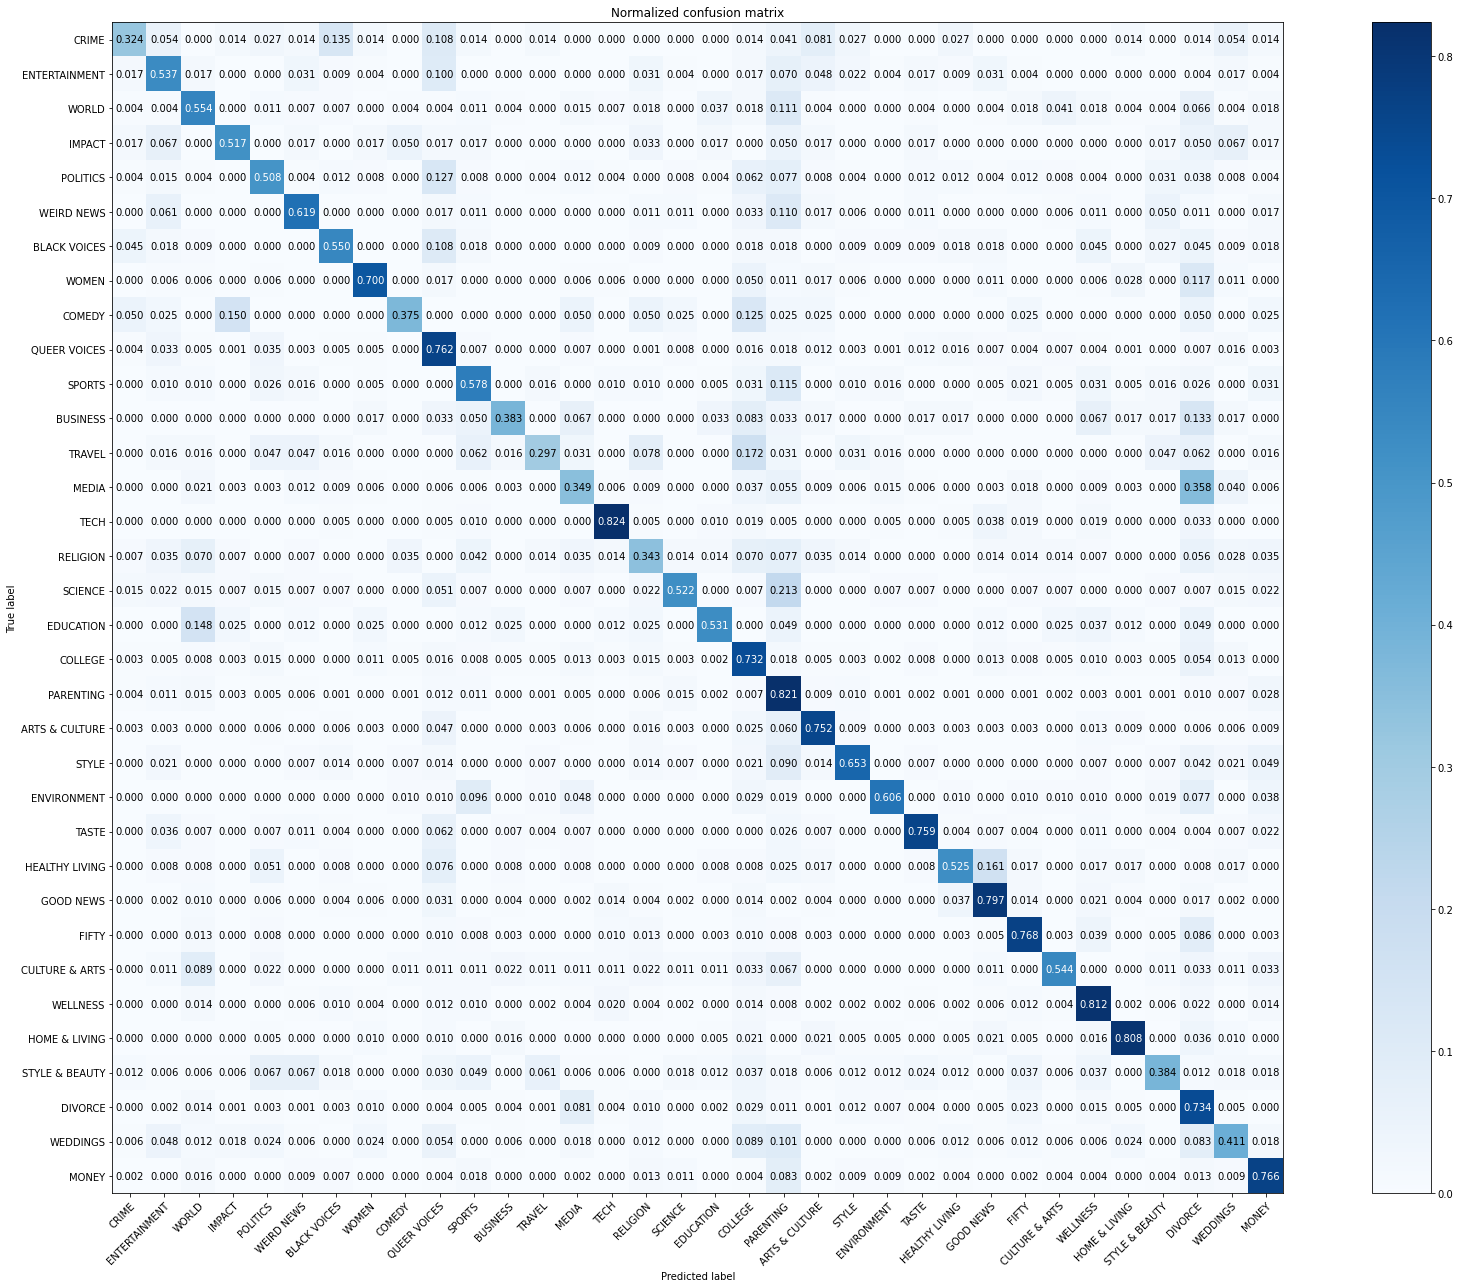

In [42]:
plot_and_store_confusion_matrix(true_categories, predicted_categories, show=True)